In [1]:
import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("imageMNIST.csv", header=None, low_memory=False)
df_y = pd.read_csv("labelMNIST.csv", header=None)

def change_type(x):
    if(isinstance(x, int)):
        return float(x)
    elif(isinstance(x, str)):
        return float(x.replace(",", "."))

df = df.applymap(change_type)

In [3]:
#sigmoide
def sigmoid(z):
    g = (1 + np.exp(-z))**(-1)
    return g

In [4]:
def sigmoidGradient(z):
    sigmoid = 1/(1+np.exp(-z))
    return sigmoid*(1-sigmoid)

In [205]:
rand_index = []
for i in range(50):
    rand_index.append(random.randint(0,df.shape[0]))

In [326]:
X = df.iloc[rand_index].values
m,n = X.shape

In [327]:
y = df_y.iloc[rand_index].values
df_encoded = pd.get_dummies(df_y[0], prefix='digit')

In [328]:
X = df.values
m,n = X.shape

In [329]:
y = df_y.values

In [302]:
def check_grad(X,y,theta,size_in,size_hidden,size_out, Lambda):
    epsolon = 1e-4
    theta1 = theta[0]
    theta2 = theta[1]
    
#     theta_p1 = theta1+epsolon 
#     theta_m1 = theta1-epsolon
    theta_p1 = np.vstack(theta1+epsolon, theta2)
    theta_m1 = np.vstack(theta1-epsolon, theta2)
    
    theta_p2 = np.vstack(theta1, theta2+epsolon)
    theta_m2 = np.vstack(theta1, theta2-epsolon)
    
    J_p1, grad1, grad2, reg_J_p1, grad1_reg, grad2_reg = costFunction(X,y,theta_p1,size_in,size_hidden,size_out, Lambda)
    J_m1, grad1, grad2, reg_J_m1, grad1_reg, grad2_reg = costFunction(X,y,theta_m1,size_in,size_hidden,size_out, Lambda)
    
    J_p2, grad1, grad2, reg_J_p2, grad1_reg, grad2_reg = costFunction(X,y,theta_p2,size_in,size_hidden,size_out, Lambda)
    J_m2, grad1, grad2, reg_J_m2, grad1_reg, grad2_reg = costFunction(X,y,theta_m2,size_in,size_hidden,size_out, Lambda)
    
    J, grad1, grad2, reg_J, grad1_reg, grad2_reg = costFunction(X,y,theta,size_in,size_hidden,size_out, Lambda)
    
    check_delta1 = (J_p1-J_m1) / (2*epsolon)
    check_delta2 = (J_p2-J_m2) / (2*epsolon)
    
    check_delta1_reg = (reg_J_p1-reg_J_m1) / (2*epsolon)
    check_delta2_reg = (reg_J_p2-reg_J_m2) / (2*epsolon)
    
    diff1 = np.abs(check_delta1 - grad1)
    diff2 = np.abs(check_delta2 - grad2)
    diff1_reg = np.abs(check_delta1_reg - grad1_reg)
    diff2_reg = np.abs(check_delta2_reg - grad2_reg)
    
    return (diff1, diff2, diff1_reg, diff2_reg)

In [303]:
def costFunction(X,y,theta,size_in,size_hidden,size_out, Lambda):
    theta1 = theta[0]
    theta2 = theta[1]
    
    m = X.shape[0]
    J = 0
    X = np.hstack((np.ones((m,1)),X))
    y_onehot = np.zeros((m,size_out))
    
    a1 = sigmoid(X.dot(theta1.T))
    a1 = np.hstack((np.ones((m,1)),a1))
    a2 = sigmoid(a1.dot(theta2.T))
    
    
    y_onehot = np.zeros((y.size, y.max()+1))
    y_onehot[np.arange(y.size),y.flatten()] = 1
    y_onehot = y_onehot[:,1:]
    
    for j in range(size_out):
        J = J + sum(-y_onehot[:,j]*np.log(a2[:,j])-(1-y_onehot[:,j])*np.log(1-a2[:,j]))
        
    J = 1/m*J
    
    reg_J = J + Lambda/(2*m)*(np.sum(theta1[:,1:]**2)+np.sum(theta2[:,1:]**2))
                                 
    grad1 = np.zeros((theta1.shape))
    grad2 = np.zeros((theta2.shape))
                                 
    for i in range(m):
        xi = X[i,:]
        a1i = a1[i,:]
        a2i = a2[i,:]
        d2 = a2i - y_onehot[i,:]
        d1 = theta2.T.dot(d2.T) * sigmoidGradient(np.hstack((1,xi.dot(theta1.T))))
        grad1 = grad1 + d1[1:][:,np.newaxis].dot(xi[:,np.newaxis].T)
        grad2 = grad2 + d2.T[:,np.newaxis].dot(a1i[:,np.newaxis].T)
                                 
    grad1 = grad1/m
    grad2 = grad2/m
                                 
    grad1_reg = grad1 + (Lambda/m)*np.hstack((np.zeros((theta1.shape[0],1)),theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m)*np.hstack((np.zeros((theta2.shape[0],1)),theta2[:,1:]))
                                 
    return J,grad1,grad2,reg_J,grad1_reg,grad2_reg

In [304]:
##peguei do site amigo https://prateekvishnu.medium.com/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528
def randInitializeXavier(size_in, size_out):
    w=np.random.randn(size_out,size_in)*np.sqrt(1/size_in) 
    return w

In [313]:
def gradientDescent(X,y,theta,alpha,nbr_iter,Lambda,input_layer_size,hidden_layer_size,num_labels):
    theta1 = theta[0]
    theta2 = theta[1]
    
    m = len(y)
    J_history = []
    
    for i in tqdm(range(nbr_iter)):
        theta = np.array([theta1, theta2], dtype=object)
        cost,grad1,grad2,reg_J,grad1_reg,grad2_reg = costFunction(X,y,theta,input_layer_size,hidden_layer_size,num_labels,Lambda)
        theta1 = theta1 - (alpha*grad1)
        theta2 = theta2 - (alpha*grad2)
        J_history.append(cost)
        
    nn_paramsFinal = np.array([theta1,theta2], dtype=object)
    return nn_paramsFinal, J_history

In [314]:
def prediction(X,theta1,theta2):
    m = X.shape[0]
    X = np.hstack((np.ones((m,1)),X))
    
    a1 = sigmoid(X.dot(theta1.T))
    a1 = np.hstack((np.ones((m,1)),a1))
    a2 = sigmoid(a1.dot(theta2.T))
    
    return np.argmax(a2,axis=1)+1

In [320]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

initial_theta1 = randInitializeXavier(input_layer_size+1,hidden_layer_size+1)
initial_theta2 = randInitializeXavier(hidden_layer_size+2,num_labels)
initial_theta = np.array([initial_theta1, initial_theta2], dtype=object)

# X,y,theta,alpha,nbr_iter,Lambda,input_layer_size,hidden_layer_size,num_labels):

theta,J_history = gradientDescent(X,y,initial_theta,0.01,300,1,input_layer_size,hidden_layer_size,num_labels)
theta1 = theta[0]
theta2 = theta[1]

In [321]:
pred = prediction(X,theta1,theta2)
print("Training Set Accuracy:",sum(pred[:,np.newaxis]==y)[0]/len(y)*100,"%")

Training Set Accuracy: 86.98 %


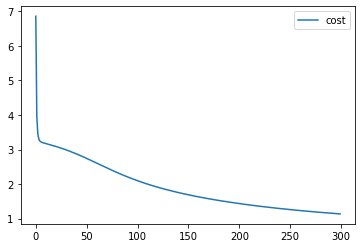

In [322]:
plt.plot(J_history, label="cost")
plt.legend()
plt.show()

In [339]:
from sklearn.neural_network import MLPClassifier
import time
start = time.time()
clf = MLPClassifier(solver='sgd', alpha=1, hidden_layer_sizes=(25,), random_state=1, activation='logistic', learning_rate_init=0.3, max_iter=300, verbose=True)
clf.fit(X, y.flatten())
end = time.time()
passed = end-start
print(passed)

Iteration 1, loss = 1.96943613
Iteration 2, loss = 1.09748659
Iteration 3, loss = 0.95305751
Iteration 4, loss = 0.92041925
Iteration 5, loss = 0.90890610
Iteration 6, loss = 0.90144589
Iteration 7, loss = 0.89908494
Iteration 8, loss = 0.89452317
Iteration 9, loss = 0.89231384
Iteration 10, loss = 0.88967210
Iteration 11, loss = 0.88696859
Iteration 12, loss = 0.88640516
Iteration 13, loss = 0.88540775
Iteration 14, loss = 0.88360903
Iteration 15, loss = 0.88558081
Iteration 16, loss = 0.88310904
Iteration 17, loss = 0.88422866
Iteration 18, loss = 0.88183852
Iteration 19, loss = 0.88049820
Iteration 20, loss = 0.88177007
Iteration 21, loss = 0.88082275
Iteration 22, loss = 0.87866952
Iteration 23, loss = 0.88061218
Iteration 24, loss = 0.87883549
Iteration 25, loss = 0.87754959
Iteration 26, loss = 0.87928373
Iteration 27, loss = 0.87859331
Iteration 28, loss = 0.87966263
Iteration 29, loss = 0.87958360
Iteration 30, loss = 0.87793879
Iteration 31, loss = 0.87772723
Iteration 32, los

In [340]:
pred = clf.predict(X)
print("Training Set Accuracy:",sum(pred[:,np.newaxis]==y)[0]/len(y)*100,"%")

Training Set Accuracy: 91.28 %
